In [1]:
import re
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, DataCollatorWithPadding
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer

In [3]:
user = "...."

#### Training

In [4]:
cache_path = f"/scratch/{user}/datasets"
dataset = load_dataset(
    "causality-grammar/logic_explanations",
    data_files={"train": "deepseek_5k_RP.parquet"},
    cache_dir=cache_path
)

In [5]:
cache_path = f"/scratch/{user}/models"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", cache_dir=cache_path)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", device_map = "auto", cache_dir=cache_path)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def preprocess_function(sample):
    source = (
        f"Answer the question based on the provided context.\n\nYour Final answer should be 0 (if False) and 1 (if True)\n\n"
        f"Question: {sample['Question']}\n\n"
        f"Answer: "
    )
    target = sample['Response']
    tokenized_source = tokenizer(source, max_length=512, truncation=True)
    tokenized_source["labels"] = sample["Response"]
    return tokenized_source

In [7]:
tokenized_dataset = dataset.map(preprocess_function)

In [8]:
finetuned_model_output_dir = f"/scratch/{user}/models/bert_finetuned"
training_args = TrainingArguments(
    output_dir=finetuned_model_output_dir,
    per_device_train_batch_size=2,  # Lowered batch size for full model
    gradient_accumulation_steps=4, # Accumulate gradients to simulate a larger batch size
    learning_rate=5e-5,
    num_train_epochs=3,
    logging_strategy="steps",
    logging_steps=200,
    save_strategy="epoch",
    report_to="none"
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    tokenizer=tokenizer
)

# Start training!
print("Starting full fine-tuning...")
trainer.train()

# Save the fully fine-tuned model and tokenizer
print("Saving the full model...")
trainer.save_model(finetuned_model_output_dir)
tokenizer.save_pretrained(finetuned_model_output_dir)

print("✅ Full fine-tuning complete!")

/tmp/ipykernel_1027409/386213511.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting full fine-tuning...


Step,Training Loss
200,0.544700
400,0.502900
600,0.543100
800,0.511900
1000,0.524500
1200,0.496100
1400,0.574500
1600,0.513300
1800,0.538900
2000,0.541100


Saving the full model...
✅ Full fine-tuning complete!


#### Inference

In [47]:
def create_prompt(question_text):
    """Creates a standardized prompt for the models."""
    return f"Answer the question based on the provided context.\n\nYour Final answer should be 0 (if False) and 1 (if True)\n\nQuestion: {question_text}\n\nAnswer:"

In [48]:
def get_batch_predictions(model, tokenizer, prompts):

    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        output= model(**inputs)
    return output.logits

In [49]:
def get_preds(logits):
    return torch.argmax(logits, dim=-1).cpu()

In [50]:
def plot_confusion_matrix(cm, classes, title):
    """Plots a confusion matrix using seaborn."""
    plt.figure(figsize=(6, 5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title); plt.ylabel('True Label'); plt.xlabel('Predicted Label'); plt.show()

In [51]:
cache_path = f"/scratch/{user}/datasets"
test_dataset = load_dataset(
    "causality-grammar/logic_explanations",
    data_files={"test": "deepseek_3.6k_RP_test.parquet"},
    cache_dir=cache_path
)["test"]

In [52]:
all_prompts = [create_prompt(ex['Question']) for ex in test_dataset]
all_true_labels = [ex['Response'] for ex in test_dataset]
all_depths = [ex['Depth'] for ex in test_dataset]

In [53]:
bert_preds = []
BATCH_SIZE = 32
prompt_loader = DataLoader(all_prompts, batch_size=BATCH_SIZE)

In [56]:
for batch in tqdm(prompt_loader, desc="BART Batches"):
    output_logits = get_batch_predictions(model, tokenizer, batch)
    bert_preds.extend([get_preds(out).item() for out in output_logits])

BART Batches: 100%|██████████| 113/113 [00:36<00:00,  3.07it/s]


In [57]:
len(bert_preds)

3600

In [58]:
results = []
for i in range(len(all_prompts)):
    results.append({
        "depth": all_depths[i], "true_label": all_true_labels[i],
        "bert_pred": bert_preds[i] if bert_preds else -1,
    })


***** Evaluation Results *****

Overall BERT Accuracy: 0.7106

--- Depth-wise Analysis ---

--- Depth: 0 (300 examples) ---
  bert Accuracy: 0.9500


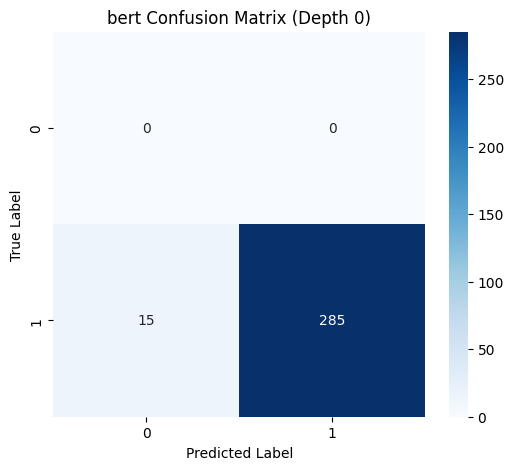


--- Depth: 1 (300 examples) ---
  bert Accuracy: 0.6767


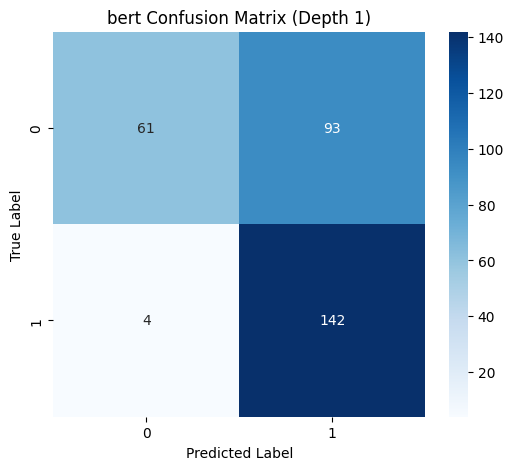


--- Depth: 2 (300 examples) ---
  bert Accuracy: 0.7567


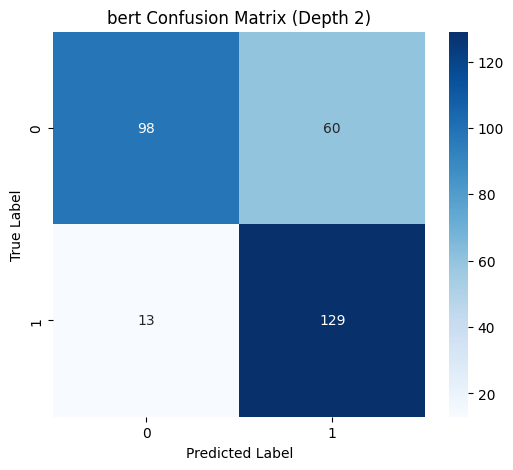


--- Depth: 3 (300 examples) ---
  bert Accuracy: 0.7967


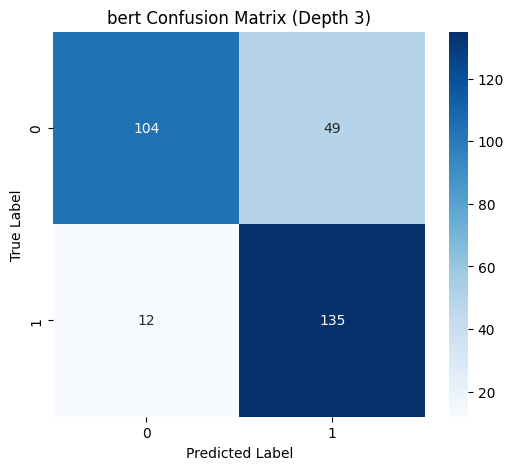


--- Depth: 4 (300 examples) ---
  bert Accuracy: 0.7800


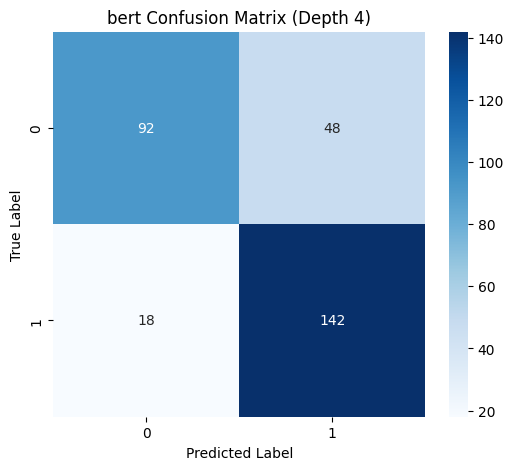


--- Depth: 5 (300 examples) ---
  bert Accuracy: 0.7933


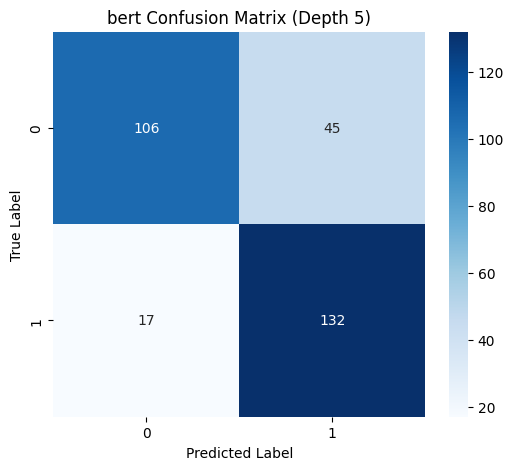


--- Depth: 6 (300 examples) ---
  bert Accuracy: 0.7867


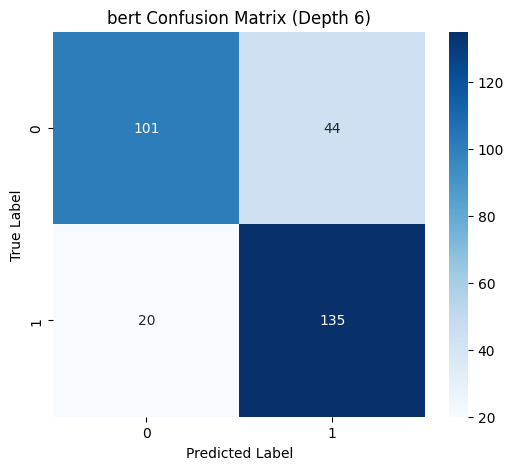


--- Depth: 7 (300 examples) ---
  bert Accuracy: 0.7233


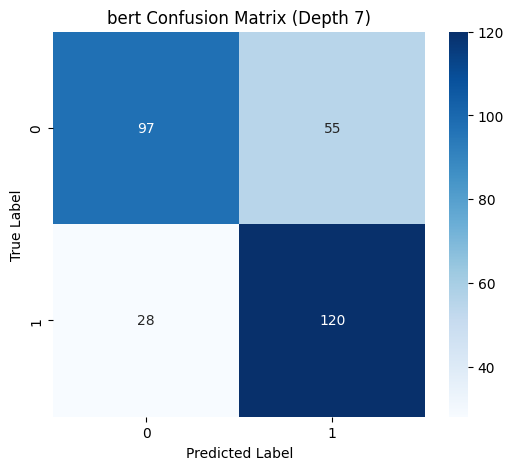


--- Depth: 8 (300 examples) ---
  bert Accuracy: 0.5933


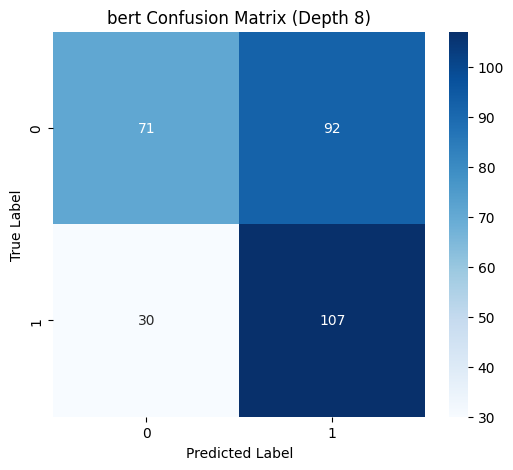


--- Depth: 9 (300 examples) ---
  bert Accuracy: 0.5967


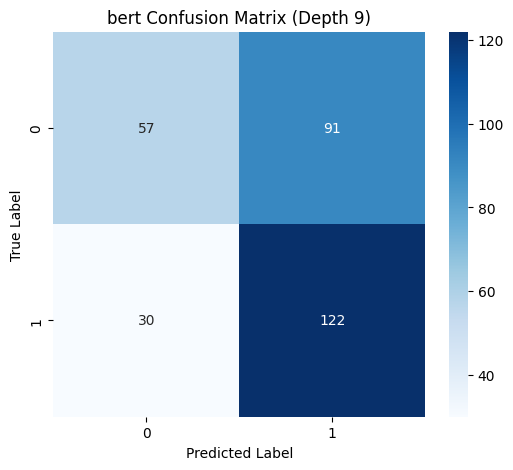


--- Depth: 10 (300 examples) ---
  bert Accuracy: 0.5300


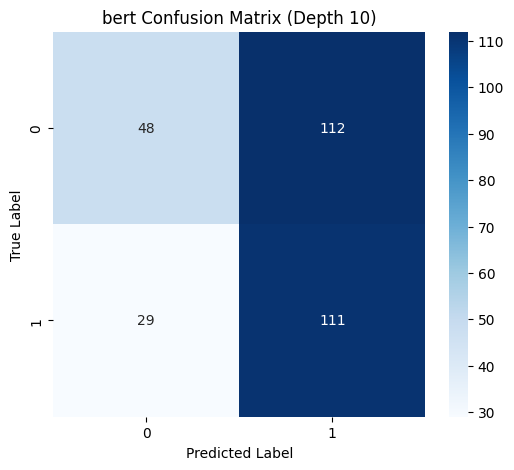


--- Depth: 11 (300 examples) ---
  bert Accuracy: 0.5433


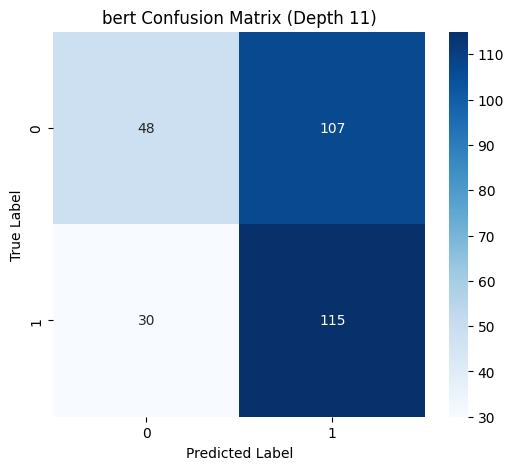

In [59]:
print("\n***** Evaluation Results *****")
accuracy_by_depth = {"depth": list(), "accuracy": list()}
results_by_depth = defaultdict(list)
for res in results: results_by_depth[res['depth']].append(res)
sorted_depths = sorted(results_by_depth.keys())

# --- Overall Accuracy ---
print(f"\nOverall BERT Accuracy: {accuracy_score(all_true_labels, bert_preds):.4f}")

print("\n--- Depth-wise Analysis ---")
for depth in sorted_depths:
    depth_results = results_by_depth[depth]
    true_labels = [r['true_label'] for r in depth_results]
    print(f"\n--- Depth: {depth} ({len(depth_results)} examples) ---")

    model_preds = {
        "bert": [r['bert_pred'] for r in depth_results] if bert_preds else None,
        # LOCAL_COMPARISON_MODEL_ID: [r['local_comp_pred'] for r in depth_results] if local_comp_preds else None,
        # "DeepSeek API": [r['deepseek_api_pred'] for r in depth_results] if deepseek_api_preds else None,
    }

    for name, preds in model_preds.items():
        if preds:
            acc = accuracy_score(true_labels, preds)
            print(f"  {name} Accuracy: {acc:.4f}")
            cm = confusion_matrix(true_labels, preds, labels=[0, 1])
            plot_confusion_matrix(cm, classes=['0', '1'], title=f'{name} Confusion Matrix (Depth {depth})')

            accuracy_by_depth["depth"].append(depth)
            accuracy_by_depth["accuracy"].append(np.round(acc, 4))

In [60]:
import pandas as pd
df = pd.DataFrame(accuracy_by_depth).rename(columns={'depth': 'Depth', 'accuracy': 'BERT Accuracy (3600 Samples)'})
print(df.to_string(index=False))

 Depth  BERT Accuracy (3600 Samples)
     0                        0.9500
     1                        0.6767
     2                        0.7567
     3                        0.7967
     4                        0.7800
     5                        0.7933
     6                        0.7867
     7                        0.7233
     8                        0.5933
     9                        0.5967
    10                        0.5300
    11                        0.5433


In [61]:
bart_acc = [0.9933 ,  0.9833, 0.7800, 0.7800, 0.7200, 0.7033, 0.7367, 0.6733, 0.6967, 0.6067, 0.6000, 0.6033]
flan_t5_acc = [0.9967 , 0.9067 ,0.9000 ,0.8567 ,0.8200 , 0.8067 ,0.8100 ,0.7067 ,0.6367 ,0.6167 ,0.5167 , 0.5300]

acc_df = pd.DataFrame({"depth": list(range(12)) , "BERT": accuracy_by_depth["accuracy"], "BART": bart_acc, "Flan T5": flan_t5_acc})

In [62]:
print(acc_df.to_string(index=False))

 depth   BERT   BART  Flan T5
     0 0.9500 0.9933   0.9967
     1 0.6767 0.9833   0.9067
     2 0.7567 0.7800   0.9000
     3 0.7967 0.7800   0.8567
     4 0.7800 0.7200   0.8200
     5 0.7933 0.7033   0.8067
     6 0.7867 0.7367   0.8100
     7 0.7233 0.6733   0.7067
     8 0.5933 0.6967   0.6367
     9 0.5967 0.6067   0.6167
    10 0.5300 0.6000   0.5167
    11 0.5433 0.6033   0.5300


In [53]:
sum(accuracy_by_depth["accuracy"]) / 12

np.float64(0.7255416666666666)

In [54]:
(0.9933 + 0.9833+0.7800+0.7800+0.7200+0.7033+0.7367+0.6733+0.6967+0.6067+0.6000+0.6033)/12

0.7397166666666667

In [55]:
(0.9967 + 0.9067 +0.9000 +0.8567 +0.8200 + 0.8067 +0.8100 +0.7067 +0.6367 +0.6167 +0.5167 + 0.5300) / 12

0.7586333333333334